# Comparison with XGBoost

This notebook compares quantile-regression-based precipitation retrievals using XGBoost and QRNNs.

In [18]:
%load_ext autoreload
%autoreload 2
import pickle
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preparation

We load the data into arrays of input data and output data. Then we randomly split into training, validation and test data.

In [3]:
from sklearn.model_selection import train_test_split
training_data = pickle.load(open("sampled_ds_SIMON.pkl", "rb"))
input_labels = [
    "temp_11_0um_nom",
    "temp_12_0um_nom",
    "total_precipitable_water_nwp",
    "T2M",
    "T2MWET",
    "TS",
    "TQV",
    "AutoSnow",
    "cloud_probability"
]
x = np.array(training_data[input_labels])
y = np.array(training_data["preci_val"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
quantiles = np.linspace(0, 1, 34)[1:-1]

We define the quantiles here as they are used for both XGBoost and the QRNN. For this, we create an equally-spaced grid covering the range [0, 1] and cut off the first and last elements.

In [4]:
quantiles = np.linspace(0, 1, 34)[1:-1]

## XGBoost regressor

Using XGBoost for quantile regression is extremely easy. It support the QR loss out of the box and also supports training on multiple quantiles.

In [6]:
# Create DMatrix object to hold the results.
xy_train = xgb.DMatrix(x_train, y_train)
xy_val = xgb.DMatrix(x_val, y_val)

booster = xgb.train(
        {
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": quantiles,
        "max_depth": 10,
    },
    xy_train,
    num_boost_round=32,
    early_stopping_rounds=2,
    evals=[(xy_train, "Training"), (xy_val, "Validation")],
)

[0]	Training-quantile:0.02705	Validation-quantile:0.02579
[1]	Training-quantile:0.02330	Validation-quantile:0.02205
[2]	Training-quantile:0.02120	Validation-quantile:0.01998
[3]	Training-quantile:0.01996	Validation-quantile:0.01877
[4]	Training-quantile:0.01920	Validation-quantile:0.01806
[5]	Training-quantile:0.01873	Validation-quantile:0.01760
[6]	Training-quantile:0.01842	Validation-quantile:0.01732
[7]	Training-quantile:0.01821	Validation-quantile:0.01712
[8]	Training-quantile:0.01806	Validation-quantile:0.01700
[9]	Training-quantile:0.01796	Validation-quantile:0.01692
[10]	Training-quantile:0.01789	Validation-quantile:0.01686
[11]	Training-quantile:0.01784	Validation-quantile:0.01683
[12]	Training-quantile:0.01780	Validation-quantile:0.01679
[13]	Training-quantile:0.01776	Validation-quantile:0.01676
[14]	Training-quantile:0.01773	Validation-quantile:0.01675
[15]	Training-quantile:0.01771	Validation-quantile:0.01673
[16]	Training-quantile:0.01769	Validation-quantile:0.01672
[17]	Tr

The predicted results from the trained booster have the shape ``(N x 32)`` with latter dimension corresponding to the 32 predicted quantiles.

In [10]:
y_pred_xgb = booster.inplace_predict(x_test)

## QRNN

Since the input data is tabular, we can use a simple fully-connected feed-forward network for the task. The ``quantnn.qrnn.QRNN`` makes this use case fairly straight forward. The code below creates a fully-connected NN with 6 hidden layers with 256 neurons and RELU activation functions.

In [7]:
from quantnn.qrnn import QRNN

qrnn = QRNN(
    n_inputs=x_test.shape[-1],
    quantiles=quantiles,
    model=(6, 256, "relu")
)

Neural networks are sensitive to the normalization of their inputs, so we create a normalizer object that uses the training data statistics to normalize the training, validation and test inputs. Its important to use the same normalizer for all data that the network may be applied to.

In [8]:
from quantnn.normalizer import MinMaxNormalizer
normalizer = MinMaxNormalizer(np.array(x_train))

x_train_n = normalizer(x_train)
x_val_n = normalizer(x_val)
x_test_n = normalizer(x_test)

In [ ]:
import torch
n_epochs = 20
optimizer = torch.optim.AdamW(qrnn.model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(
    training_data=(x_train_n, np.array(y_train)),
    validation_data=(x_val_n, np.array(y_val)),
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=n_epochs,
    device="cpu",
    batch_size=256
)

Output()

In [12]:
with torch.no_grad():
    y_pred_qrnn = qrnn.predict(x_test_n).numpy()

## Precipitation estimations

To compare the two approaches, we briefly assess their accuracy in providing quantitative precipitation estimates. We will use two different quantities as point estimators the mean of the posterior distribution and its median and compare both of them to illustrate their different properties.

In [13]:
from quantnn.quantiles import posterior_mean, posterior_quantiles

# The 'posterior_mean' calculates the mean of the distribution represented by the predicted quantiles.
y_xgb_mean = posterior_mean(y_pred=y_pred_xgb, quantiles=quantiles)
y_qrnn_mean = posterior_mean(y_pred=y_pred_qrnn, quantiles=quantiles)

# The 'posterior_quantiles' calculates arbitrary quantiles of the distribution represented by the predicted quantiles.
# Thils allows us to compute the median although we have not directly predicted it.
y_xgb_median = posterior_quantiles(y_pred=y_pred_xgb, quantiles=quantiles, new_quantiles=[0.5])[..., 0]
y_qrnn_median = posterior_quantiles(y_pred=y_pred_qrnn, quantiles=quantiles, new_quantiles=[0.5])[..., 0]

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

err_xgb_mean = y_test - y_xgb_mean
err_qrnn_mean = y_test - y_qrnn_mean
err_xgb_median = y_test - y_xgb_median
err_qrnn_median = y_test - y_qrnn_median

bias_xgb_mean = np.mean(err_xgb_mean).mean()
bias_qrnn_mean = np.mean(err_xgb_mean).mean()
bias_xgb_median = np.mean(err_xgb_median).mean()
bias_qrnn_median = np.mean(err_xgb_median).mean()

mse_xgb_mean = mean_squared_error(y_test, y_xgb_mean)
mse_xgb_median = mean_squared_error(y_test, y_xgb_median)
mse_qrnn_mean = mean_squared_error(y_test, y_qrnn_mean)
mse_qrnn_median = mean_squared_error(y_test, y_qrnn_median)

mae_xgb_mean = mean_absolute_error(y_test, y_xgb_mean)
mae_xgb_median = mean_absolute_error(y_test, y_xgb_median)
mae_qrnn_mean = mean_absolute_error(y_test, y_qrnn_mean)
mae_qrnn_median = mean_absolute_error(y_test, y_qrnn_median)

r2_xgb_mean = r2_score(y_test, y_xgb_mean)
r2_xgb_median = r2_score(y_test, y_xgb_median)
r2_qrnn_mean = r2_score(y_test, y_qrnn_mean)
r2_qrnn_median = r2_score(y_test, y_qrnn_median)

results = pd.DataFrame({
    "Method": ["XGBoost"] * 2 + ["QRNN"] * 2,
    "Quantity": ["Mean", "Median"] * 2,
    "Bias": [bias_xgb_mean, bias_xgb_median, bias_qrnn_mean, bias_qrnn_median],
    "MSE": [mse_xgb_mean, mse_xgb_median, mse_qrnn_mean, mse_qrnn_median],
    "MAE": [mae_xgb_mean, mae_xgb_median, mae_qrnn_mean, mae_qrnn_median],
    "R2": [r2_xgb_mean, r2_xgb_median, r2_qrnn_mean, r2_qrnn_median],
})
results   

/home/simon/miniconda3/envs/quantnn/lib/python3.10/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/home/simon/miniconda3/envs/quantnn/lib/python3.10/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/home/simon/miniconda3/envs/quantnn/lib/python3.10/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/home/simon/miniconda3/envs/quantnn/lib/python3.10/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


,Method,Quantity,Bias,MSE,MAE,R2
0,XGBoost,Mean,0.003106,0.020053,0.051002,0.352149
1,XGBoost,Median,0.026912,0.022581,0.046418,0.270457
2,QRNN,Mean,0.003106,0.020344,0.055477,0.342738
3,QRNN,Median,0.026912,0.020863,0.047213,0.325974


/tmp/ipykernel_4137/3235382130.py:21: RuntimeWarning: invalid value encountered in divide
  img /= img.sum(1, keepdims=True)


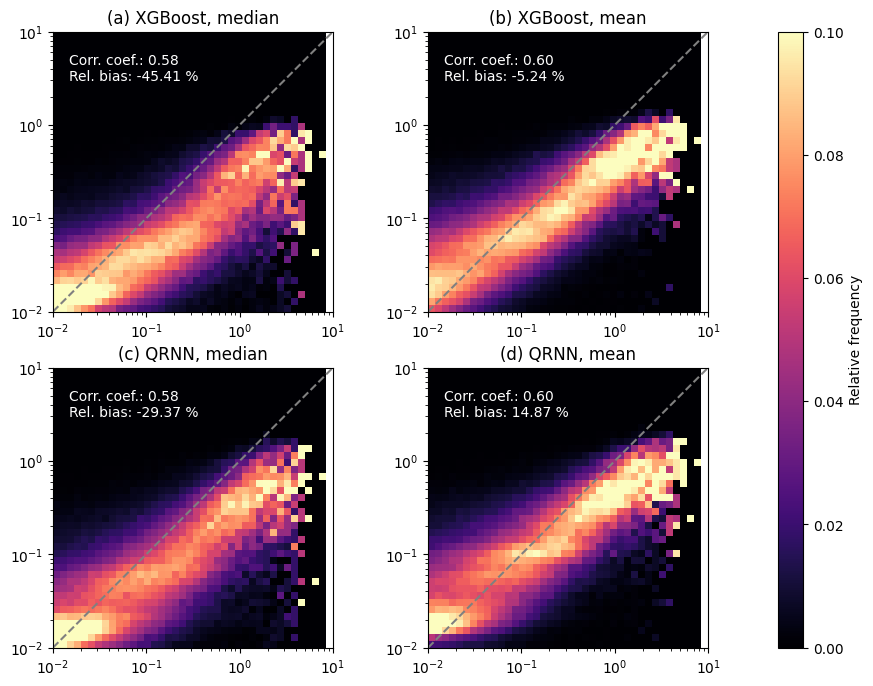

In [38]:
from matplotlib.gridspec import GridSpec
def make_scatter_plot(ax, y_true, y_pred, cmap="magma"):
    """
    Draw scatter plot of predicted results.

    This function normalizes each column in the scatter plot by the total number of samples falling
    into the corresponding range of reference values. While, in contrast to plotting the conditional
    distribution, this does not allow for a meaningul mathematical interpretation, it is typically
    the most pleasant to look at, while still keeping rare, heavy precip samples visible.

    Args:
        ax: A matplotlibt Axes object into which to draw the scatter plot.
        y_true: The true precipitation estimates.
        y_pred: The predicted precipitation values.

    Return:
        The matplotlib scalar mappable that can be used to draw the color bar.
    """
    bins = np.logspace(-2, 1, 41)
    img = np.histogram2d(y_true.ravel(), y_pred.ravel(), bins=bins)[0]
    img /= img.sum(1, keepdims=True)
    mappable = ax.pcolormesh(bins, bins, img.T, vmin=0, vmax=0.1, cmap=cmap)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_aspect(1.0)

    corr_coef = np.corrcoef(y_pred.ravel(), y_true.ravel())[0, 1]
    rel_bias = 100 * (y_pred - y_true).mean() / y_true.mean()

    stats = f"Corr. coef.: {corr_coef:0.2f}\nRel. bias: {rel_bias:2.2f} %"
    ax.text(1.5e-2, 3, s=stats, color="w")
    
    return mappable

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 3, width_ratios=[1.0, 1.0, 0.075])

ax = fig.add_subplot(gs[0, 0])
make_scatter_plot(ax, y_test, y_xgb_median)
ax.set_title("(a) XGBoost, median")

ax = fig.add_subplot(gs[0, 1])
make_scatter_plot(ax, y_test, y_xgb_mean)
ax.set_title("(b) XGBoost, mean")

ax = fig.add_subplot(gs[1, 0])
make_scatter_plot(ax, y_test, y_qrnn_median)
ax.set_title("(c) QRNN, median")

ax = fig.add_subplot(gs[1, 1])
m = make_scatter_plot(ax, y_test, y_qrnn_mean)
ax.set_title("(d) QRNN, mean")

ax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, cax=ax, label="Relative frequency")



## Precipitation detection

One advantage of the quantile output is that it can be used to detect precipitation at arbitrary thresholds. To detect precipitation, for example, we can simply calculate the probability of the precipitation exceeding the minimum precipitation in the training data.

In [73]:
min_precip

0.00124

In [78]:

from quantnn.quantiles import probability_larger_than
min_precip = y_train[y_train > 0].min()

pop_xgb = probability_larger_than(y_pred=y_pred_xgb, y=min_precip, quantiles=quantiles)
pop_qrnn = probability_larger_than(y_pred=y_pred_qrnn, y=min_precip, quantiles=quantiles)

To demonstrate the advantage of using the probabilistic prediction from the quantile regression, we compare the skill of the predcited probability of precipitation (``pop``) against just using the mean to detect precipitation.

For the QRNN, at least, there is a slight improvement in detection skill, when the propabilistic estimate is used. For the XGBoost prediction, there seems to be some issue. This may be related to having strict zeros in the dataset and may be counteracted by replacing 0 precipi by small, random values. But this will require further investigation.

Text(0.5, 1.0, 'Precipitation detection')

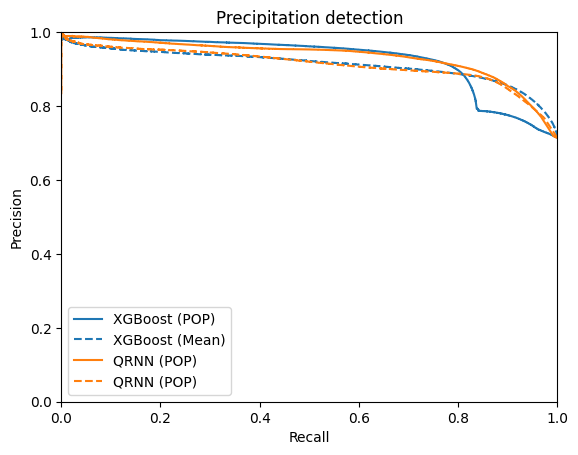

In [79]:
from sklearn.metrics import precision_recall_curve
prc_xgb_pop, rec_xgb_pop, _ = precision_recall_curve(y_test >= min_precip, pop_xgb)
prc_qrnn_pop, rec_qrnn_pop, _ = precision_recall_curve(y_test >= min_precip, pop_qrnn)
prc_xgb_mean, rec_xgb_mean, _ = precision_recall_curve(y_test >= min_precip, y_xgb_mean)
prc_qrnn_mean, rec_qrnn_mean, _ = precision_recall_curve(y_test >= min_precip, y_qrnn_mean)

plt.plot(rec_xgb_pop, prc_xgb_pop, c="C0", label="XGBoost (POP)")
plt.plot(rec_xgb_mean, prc_xgb_mean, c="C0", ls="--", label="XGBoost (Mean)")
plt.plot(rec_qrnn_pop, prc_qrnn_pop, c="C1", label="QRNN (POP)")
plt.plot(rec_qrnn_mean, prc_qrnn_mean, c="C1", ls="--", label="QRNN (POP)")
plt.legend()

plt.ylim([0, 1.0])
plt.xlim([0, 1.0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precipitation detection")